In [ ]:
#LOAD DEPENDENCIES
import os
import cv2
import time
import pickle
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras import applications, Model, layers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as selected_model, preprocess_input

#PREVENT ERROR UNCESSARY MESSAGES
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
#Tweakable parameters
model_kind = "KD"

In [ ]:
#Architecture
model_architecture = "teacher"
print(model_architecture)

teacher


In [ ]:
#Custom Functions
model_architecture_name = model_kind + model_architecture

model_path = "models/" + model_kind + '-' + '/'

fig_path = 'figures/' + model_kind + '/'

#Load Model Function
def load_m(directory):
    with open('models/' + model_kind + '/' + directory + '/' + model_architecture + '.json', 'r') as json_file:
        model = json_file.read()
        model = model_from_json(model)
        model.load_weights('models/' + model_kind + '/' + directory + '/' + model_architecture + '.h5')
        return model

#Load History
def load_h(file):
    with open('models/' + model_kind + '/' + model_architecture + '/' + model_architecture + '.history', 'rb') as file_pi:
        his = pickle.load(file_pi)
    return his

#Save Model Function
def save_m(directory, model):
    if not os.path.exists(directory):
        os.makedirs(directory)
    model.save(directory + '/' + model_architecture + '.h5')
    print("model saved")

#Save History Function
def save_h(directory, his):
    if not os.path.exists(directory):
        os.makedirs(directory)

    with open(directory + '/' + model_architecture + '.history', 'wb') as file_pi:
        pickle.dump(his, file_pi)
    print("history saved")

#Save Figure Function
def save_fig(directory, fig_name):
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(directory + '/' + fig_name + '.tiff', bbox_inches='tight', dpi=600, format='tiff')

In [ ]:
#LOAD THE DATA
main_data_dir = "ds/"

train_data_dir = main_data_dir + "train/"

validation_data_dir = main_data_dir + "val/"

test_data_dir = main_data_dir + "test/"

img_rows, img_cols = 224, 224

input_shape = (img_rows,img_cols,3)
model_input = Input(shape=input_shape)
print("Data folders found!")
print("The Input size is set to ", model_input) 

model_path = "models/" + model_kind + '/'

Data folders found!
The Input size is set to  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [ ]:
#DATA GENERATORS

batch_size = 4

seed = 42

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
         
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        seed=seed)

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        seed=seed,
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        seed=seed,
        shuffle=False)

#CHECK  THE NUMBER OF SAMPLES
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

if nb_train_samples == 0:
    print("NO DATA TRAIN FOUND! Please check your train data path and folders!")
else:
    print(nb_train_samples,"Train samples found!")
    
if nb_validation_samples == 0:
    print("NO DATA VALIDATION FOUND! Please check your validation data path and folders!")
    print("Check the data folders first!")
else:
    print(nb_validation_samples, "Validation samples found!")
    
if nb_test_samples == 0:
    print("NO DATA TEST FOUND! Please check your test data path and folders!")
    print("Check the data folders first!")
else:
    print(nb_test_samples, "Test samples found!")

#check the class indices
train_generator.class_indices
validation_generator.class_indices

#true labels
Y_test=validation_generator.classes
Y_test_2=test_generator.classes

num_classes= len(train_generator.class_indices)

print('Model set to train', num_classes, 'classes')

if nb_train_samples and nb_validation_samples > 0:
    print("Generators are set!")
    print("Check if dataset is complete and has no problems before proceeding.")

Found 1990 images belonging to 199 classes.
Found 1194 images belonging to 199 classes.
Found 796 images belonging to 199 classes.
1990 Train samples found!
1194 Validation samples found!
796 Test samples found!
Model set to train 199 classes
Generators are set!
Check if dataset is complete and has no problems before proceeding.


In [ ]:
#Hyper-parameter settings
batch_size = batch_size
epochs = 30
dropout_rate = 0.5
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
import itertools

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

In [ ]:
#Load the trained model into model variable for consitency.
model = load_model(model_path + model_architecture + '/' + model_architecture +'.h5')
model.compile(metrics=['accuracy'], loss=CategoricalCrossentropy(from_logits=True))
print("The " + model_architecture + ' ' + model_kind + " model is Loaded")
model.summary()

The teacher KD model is Loaded
Model: "ablation_final-PROPOSEDMiniMobileNetV2-39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
___________________________

In [ ]:
#Load the history of the trained model
from pickle import load

history = load_h(model_architecture)
print("History of " + model_architecture_name + " successfully loaded!")

History of KDteacher successfully loaded!


In [ ]:
#Sanity check
model.evaluate(validation_generator, return_dict=True)

299/299 [==============================] - 10s 27ms/step - loss: 0.3358 - accuracy: 0.9079


{'loss': 0.3358220160007477, 'accuracy': 0.9078726768493652}

In [ ]:
#Test the model
model.evaluate(test_generator, return_dict=True)

199/199 [==============================] - 6s 31ms/step - loss: 0.3420 - accuracy: 0.9095


{'loss': 0.34196481108665466, 'accuracy': 0.909547746181488}

In [ ]:
#Validation Model Results

#evaluate accuracy
y_pred = model.predict(validation_generator, 
                                 nb_validation_samples/batch_size, workers=1)

accuracy = accuracy_score(Y_test, y_pred.argmax(axis=-1))
print('The accuracy of the ' + model_kind + ' ' + model_architecture + ' is: ', accuracy)

#evaluate mean squared error
mse = mean_squared_error(Y_test, y_pred.argmax(axis=-1))
print('The MSE of the ' + model_kind + ' ' + model_architecture + ' is: ', mse)

#evaluate mean squared log error
msle = mean_squared_log_error(Y_test, y_pred.argmax(axis=-1))  
print('The MSLE of the ' + model_kind + ' ' + model_architecture + ' is: ', msle)

The accuracy of the KD teacher is:  0.9078726968174204
The MSE of the KD teacher is:  638.8283082077052
The MSLE of the KD teacher is:  0.16114358963673422


In [ ]:
#Test Model Results

#evaluate accuracy
y_pred_2 = model.predict(test_generator, 
                                 nb_test_samples/batch_size, workers=1)

accuracy_2 = accuracy_score(Y_test_2, y_pred_2.argmax(axis=-1))
print('The accuracy of the ' + model_kind + ' ' + model_architecture + ' is: ', accuracy_2)

#evaluate mean squared error
mse_2 = mean_squared_error(Y_test_2, y_pred_2.argmax(axis=-1))
print('The MSE of the ' + model_kind + ' ' + model_architecture + ' is: ', mse_2)

#evaluate mean squared log error
msle_2 = mean_squared_log_error(Y_test_2, y_pred_2.argmax(axis=-1))  
print('The MSLE of the ' + model_kind + ' ' + model_architecture + ' is: ', msle_2)

The accuracy of the KD teacher is:  0.9095477386934674
The MSE of the KD teacher is:  385.46608040201005
The MSLE of the KD teacher is:  0.059406669153867844


In [ ]:
#Cost-efficiency

model_path = "models/" + model_kind + '/' + model_architecture + '/' + model_architecture + '.h5'

def cost_compute():
    from keras_flops import get_flops
    from keras.utils.layer_utils import count_params
    flops  = float("{0:.2f}".format(get_flops(Model(model.input, model.output), batch_size=1)/ 10 ** 9))
    params = float("{0:.2f}".format(model.count_params() / 10 ** 6))
    trainable_count = float("{0:.2f}".format(count_params(model.trainable_weights) / 10 ** 6))
    model_file_size = float("{0:.2f}".format(os.stat(model_path).st_size / 10 ** 6))
    formatted_acc = float("{0:.4f}".format(accuracy))
    print("The FLOPS of the " + model_kind + ' ' + model_architecture + " is:", flops, "FLOPS")
    print("The parameter size of the " + model_kind + ' ' + model_architecture + " is:", params, "M")
    print("The model file size of the " + model_kind + ' ' + model_architecture + " is:", model_file_size, "MB")
    print("The model accuracy of the " + model_kind +' ' + model_architecture + " is:", formatted_acc)

cost_compute()

The FLOPS of the KD teacher is: 0.43 FLOPS
The parameter size of the KD teacher is: 0.58 M
The model file size of the KD teacher is: 2.67 MB
The model accuracy of the KD teacher is: 0.9079


In [ ]:
#Figure
dpi = 1000
plt.rcParams.update({'figure.dpi': dpi})
figsize = (12, 12)

#Markers
marker_train_accuracy = 's'
marker_validation_accuracy = 'x'
marker_train_loss = 'o'
marker_validation_loss = '|'
marker_fillstyle_train = 'none'
marker_fillstyle_validation = 'none'
marker_plot_markersize = 25
marker_plot_markerwidth = 3

#Lines
line_style_train = '-' 
line_style_validation = '--'
line_width_train = '5'
line_width_val = line_width_train
line_color_train_accuracy = 'black'
line_color_val_accuracy = 'black'
line_color_train_loss = 'black'
line_color_val_loss = 'black'

#Labels
train_accuracy_label = 'Train ' + 'Acc'
validation_accuracy_label = 'Val ' + 'Acc'
train_loss_label = 'Train ' + 'Loss'
validation_loss_label = 'Val ' 'Loss'
x_label_font_size = 56
y_label_font_size = x_label_font_size
x_label_font = 'Tahoma'
y_label_font = x_label_font
# x_label_fontweight = 'bold'
# y_label_fontweight = x_label_fontweight

#Ticks
spine_axis_thickness = 4
tick_font_size = 42
tick_length = 12
tick_width = spine_axis_thickness

#Legend
legend_border_pad = 0.35
legend_line_width = 5
legend_font_size = 50
legend_edge_color = 'black'
legend_label_spacing = 0.5
legend_location = 'best'
legend_ncol = 1
legend_font = 'Tahoma'
legend_has_frame = True

In [ ]:
history["distillation_loss"]

[0.2607504725456238,
 0.2745566666126251,
 0.30606359243392944,
 0.2589201331138611,
 0.2682275176048279,
 0.26898396015167236,
 0.2409755289554596,
 0.2897563576698303,
 0.26167672872543335,
 0.26253315806388855,
 0.2011081874370575,
 0.3176337480545044,
 0.26548904180526733,
 0.20559702813625336,
 0.27484941482543945,
 0.2146606743335724,
 0.26726579666137695,
 0.29471951723098755,
 0.22976359724998474,
 0.2540079653263092,
 0.3000440001487732,
 0.19441552460193634,
 0.19634875655174255,
 0.2061730921268463,
 0.22393804788589478,
 0.19251969456672668,
 0.2510818541049957,
 0.20103171467781067,
 0.19267776608467102,
 0.21493688225746155]

<Figure size 7200x7200 with 0 Axes>

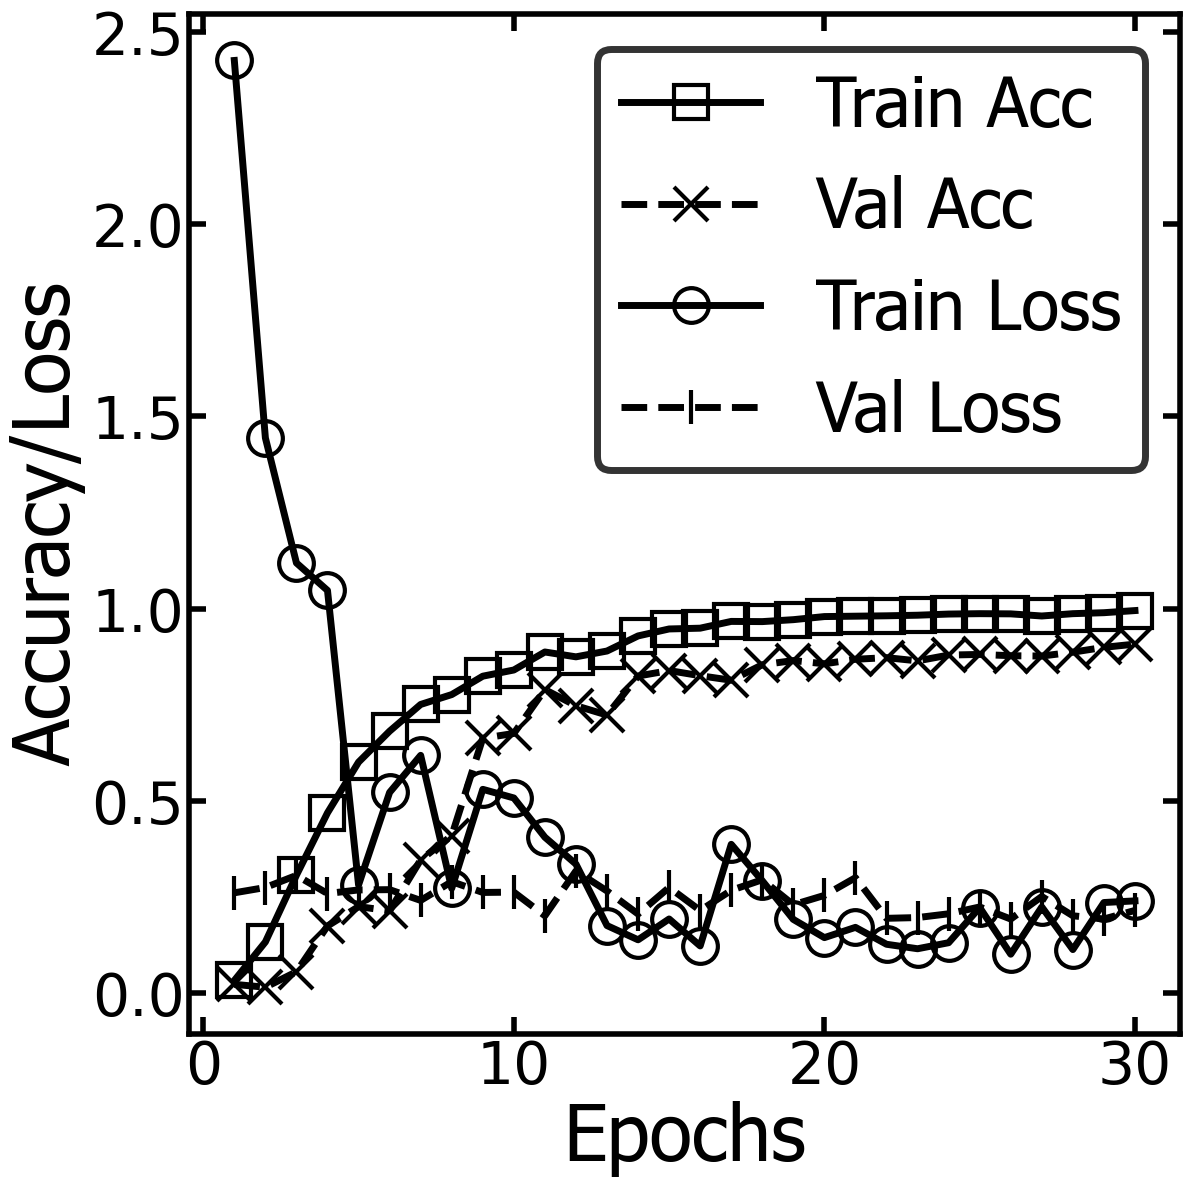

In [ ]:
#Accuracy and Loss Graph

plt.style.use("default")
plt.figure(figsize = figsize, 
           dpi = 600, 
           edgecolor = 'black', 
           facecolor = 'white', 
           linewidth = 0)
plt.tight_layout()
plt.rc('xtick', labelsize = tick_font_size, direction="in") 
plt.rc('ytick', labelsize = tick_font_size, direction="in") 

fig, ax = plt.subplots(figsize = figsize)
plt.gcf().subplots_adjust(bottom = 0.15)
plt.setp(ax.spines.values(), linewidth = spine_axis_thickness)

plt.tick_params(length = tick_length, 
                width = tick_width, 
                right = True, 
                top = True)

plt.plot(np.arange(1, epochs + 1), 
         history["accuracy"], 
         mew = marker_plot_markerwidth, 
         color = line_color_train_accuracy, 
         lw = line_width_train, 
         marker = marker_train_accuracy, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_train, 
         ls = line_style_train, 
         label = train_accuracy_label)

plt.plot(np.arange(1, epochs + 1), 
         history["val_accuracy"], 
         mew = marker_plot_markerwidth, 
         color = line_color_val_accuracy, 
         lw = line_width_val, 
         marker = marker_validation_accuracy, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_validation, 
         ls = line_style_validation,  
         label = validation_accuracy_label)

plt.plot(np.arange(1, epochs + 1), 
         history["loss"], 
         mew = marker_plot_markerwidth, 
         color = line_color_train_loss, 
         lw = line_width_train, 
         marker = marker_train_loss, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_train, 
         ls = line_style_train, label = train_loss_label)

plt.plot(np.arange(1, epochs + 1), 
         history["distillation_loss"], 
         mew = marker_plot_markerwidth, 
         color = line_color_val_loss, 
         lw = line_width_val, 
         marker = marker_validation_loss, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_validation, 
         ls = line_style_validation,  
         label = validation_loss_label)

plt.xlabel("Epochs", fontfamily = x_label_font, fontsize = x_label_font_size, color ='black')
plt.ylabel("Accuracy/Loss", fontfamily = y_label_font, fontsize = y_label_font_size, color = 'black')

legend = plt.legend(loc = legend_location, 
                    ncol = legend_ncol, 
                    frameon = legend_has_frame, 
                    fontsize=legend_font_size, 
                    edgecolor=legend_edge_color, 
                    borderpad=legend_border_pad, 
                    labelspacing=legend_label_spacing)

frame = legend.get_frame()
legend.get_frame().set_linewidth(legend_line_width)
legend.get_frame().set_edgecolor(legend_edge_color)
plt.setp(legend.texts, family = legend_font)

plt.tight_layout()
save_fig(fig_path + model_architecture, model_architecture + '-AccuracyLossGraph')

In [ ]:
#Confusion Matrix

fontsize=12

fontsize_plot=20

def confusion_matrix_test(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title= '',
                          cmap=plt.cm.PuBuGn):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=fontsize_plot)
    plt.colorbar(orientation='vertical')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.yticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, verticalalignment="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = plt.text(j, i, cm[i, j],
                 fontfamily = 'Tahoma', 
                 fontsize=fontsize_plot, weight='bold',
                 horizontalalignment="center", verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "white")
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), 
        path_effects.Normal()]),

    
    plt.tight_layout()
    plt.ylabel('', fontfamily = 'Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.xlabel('', fontfamily = 'Tahoma', fontsize=fontsize)

#%% print classification report and plot confusion matrix
plt.style.use("default")
target_names = validation_generator.class_indices
print(classification_report(Y_test, y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix_test = confusion_matrix(Y_test, y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
# plt.figure(figsize=(5.25, 5.25), dpi=600)
# confusion_matrix_test(cnf_matrix_test, classes=target_names)
# plt.tight_layout()

# save_fig(fig_path + model_architecture, model_architecture + '-ConfusionMatrix-production')
# plt.show()

                                    precision    recall  f1-score   support

                            actual     1.0000    1.0000    1.0000         6
                      adjudication     1.0000    0.5000    0.6667         6
                    administration     0.7500    1.0000    0.8571         6
                         advisable     1.0000    0.8333    0.9091         6
                       afewdaysago     1.0000    1.0000    1.0000         6
                         affidavit     1.0000    0.8333    0.9091         6
                          allofyou     1.0000    1.0000    1.0000         6
                         amendment     0.8000    0.6667    0.7273         6
                      andindefault     1.0000    1.0000    1.0000         6
                        areyousure     1.0000    0.6667    0.8000         6
                 asearlyaspossible     1.0000    1.0000    1.0000         6
                           balance     0.5000    0.5000    0.5000         6
           

c:\users\franc\anaconda3\envs\replicate\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\franc\anaconda3\envs\replicate\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\franc\anaconda3\envs\replicate\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Confusion Matrix

fontsize=12

fontsize_plot=20

def confusion_matrix_test(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title= '',
                          cmap=plt.cm.PuBuGn):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=fontsize_plot)
    plt.colorbar(orientation='vertical')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.yticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, verticalalignment="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = plt.text(j, i, cm[i, j],
                 fontfamily = 'Tahoma', 
                 fontsize=fontsize_plot, weight='bold',
                 horizontalalignment="center", verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "white")
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), 
        path_effects.Normal()]),

    
    plt.tight_layout()
    plt.ylabel('', fontfamily = 'Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.xlabel('', fontfamily = 'Tahoma', fontsize=fontsize)

#%% print classification report and plot confusion matrix
plt.style.use("default")
target_names = train_generator.class_indices
print(classification_report(Y_test_2, y_pred_2.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix_test = confusion_matrix(Y_test_2, y_pred_2.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
# plt.figure(figsize=(5.25, 5.25), dpi=600)
# confusion_matrix_test(cnf_matrix_test, classes=target_names)
# plt.tight_layout()

# save_fig(fig_path + model_architecture, model_architecture + '-ConfusionMatrix-production')
# plt.show()

                                    precision    recall  f1-score   support

                            actual     1.0000    1.0000    1.0000         4
                      adjudication     1.0000    0.7500    0.8571         4
                    administration     0.8000    1.0000    0.8889         4
                         advisable     1.0000    1.0000    1.0000         4
                       afewdaysago     1.0000    1.0000    1.0000         4
                         affidavit     1.0000    1.0000    1.0000         4
                          allofyou     1.0000    1.0000    1.0000         4
                         amendment     1.0000    1.0000    1.0000         4
                      andindefault     1.0000    1.0000    1.0000         4
                        areyousure     1.0000    1.0000    1.0000         4
                 asearlyaspossible     1.0000    1.0000    1.0000         4
                           balance     0.8000    1.0000    0.8889         4
           

c:\users\franc\anaconda3\envs\replicate\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\franc\anaconda3\envs\replicate\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\franc\anaconda3\envs\replicate\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
